# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.65
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара (12.10.2021г.). Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

### Подключение библиотек и скриптов

In [23]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
matplotlib.rcParams.update({'font.size': 14})

### Функция для оптимизации типов

In [26]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [27]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [28]:
train = pd.read_csv('C:/Users/User/train.csv')
test = pd.read_csv('C:/Users/User/test.csv')

In [29]:
print('Строк в трейне:', train.shape[0])
print('Строк в тесте', test.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [30]:
train.shape[1] - 1 == test.shape[1]

True

In [31]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [32]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Приведение типов

In [33]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [34]:
train['Id'] = train['Id'].astype(str)
test['Id'] = test['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [35]:
train = optimizing_df(train)
test = optimizing_df(test)

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   object  
 1   DistrictId     5000 non-null   category
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

### Изучение данных

#### Целевая переменная

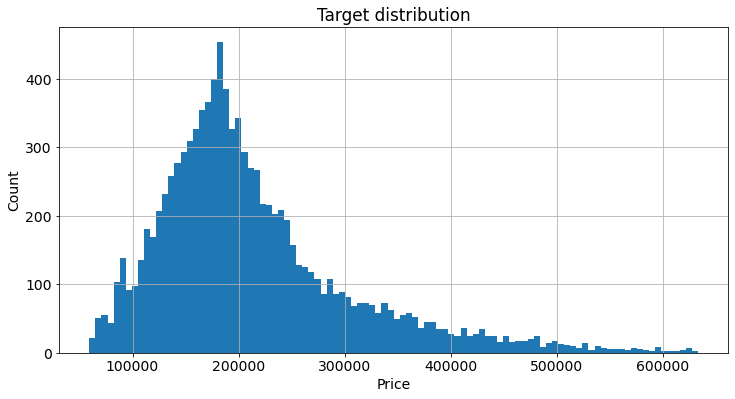

In [43]:
plt.figure(figsize = (12, 6))

train['Price'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [44]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839512,21.058718,86.241112,28.561113,5.241148,6.775974,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Номинативные переменные

In [45]:
train.select_dtypes(include='object').columns.tolist()

['Id']

### Обработка выбросов

#### Rooms

In [46]:
train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [48]:
train['Rooms_outlier'] = 0
train.loc[(train['Rooms'] == 0) | (train['Rooms'] >= 6), 'Rooms_outlier'] = 1
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,0
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,0
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,0
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,0
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,0


In [49]:
train.loc[train['Rooms'] == 0, 'Rooms'] = 1
train.loc[train['Rooms'] >= 6, 'Rooms'] = train['Rooms'].median()

In [50]:
train['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### KitchenSquare

In [51]:
train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [52]:
train['KitchenSquare'].quantile(.975), train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [53]:
condition = (train['KitchenSquare'].isna()) \
             | (train['KitchenSquare'] > train['KitchenSquare'].quantile(.975))
        
train.loc[condition, 'KitchenSquare'] = train['KitchenSquare'].median()

train.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [54]:
train['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### HouseFloor, Floor

In [55]:
train['HouseFloor'].value_counts()

17     2331
9      1389
12     1074
5      1031
14      625
16      576
1       497
25      374
22      343
0       269
24      176
8       141
10      135
4       134
3       127
15      123
19      108
20      105
18       89
7        59
6        58
2        48
23       40
21       33
11       28
13       27
30       21
40        7
27        6
32        4
37        4
28        3
99        2
39        2
48        2
38        1
31        1
45        1
117       1
29        1
44        1
36        1
26        1
47        1
Name: HouseFloor, dtype: int64

In [56]:
train['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

In [57]:
(train['Floor'] > train['HouseFloor']).sum()

1825

In [58]:
train['HouseFloor_outlier'] = 0
train.loc[train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train.loc[train['Floor'] > train['HouseFloor'], 'HouseFloor_outlier'] = 1

In [59]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['HouseFloor'].median()

In [60]:
floor_outliers = train.loc[train['Floor'] > train['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [61]:
train.loc[floor_outliers, 'Floor'] = train.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [62]:
(train['Floor'] > train['HouseFloor']).sum()

0

#### HouseYear

In [63]:
train['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [64]:
train.loc[train['HouseYear'] > 2021, 'HouseYear'] = 2021

In [65]:
train['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1910       1
1928       1
1916       1
1947       1
1914       1
Name: HouseYear, Length: 96, dtype: int64

### Обработка пропусков

In [66]:
train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [67]:
train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,3.0
3,53.352982,52.731510,9.0
4,39.649193,23.776169,7.0
5,80.384476,46.683720,12.0
6,62.254112,37.160378,7.0
7,80.312927,NaN,3.0
8,64.511436,NaN,3.0
9,46.461411,18.915552,8.0


#### LifeSquare

In [68]:
train['LifeSquare_nan'] = train['LifeSquare'].isna() * 1

condition = (train['LifeSquare'].isna()) \
             & (~train['Square'].isna()) \
             & (~train['KitchenSquare'].isna())
        
train.loc[condition, 'LifeSquare'] = train.loc[condition, 'Square'] \
                                            - train.loc[condition, 'KitchenSquare'] - 3

In [69]:
train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,3.0
3,53.352982,52.731510,9.0
4,39.649193,23.776169,7.0
5,80.384476,46.683720,12.0
6,62.254112,37.160378,7.0
7,80.312927,74.312927,3.0
8,64.511436,58.511436,3.0
9,46.461411,18.915552,8.0


#### Healthcare_1

In [70]:
train.drop('Healthcare_1', axis=1, inplace=True)

In [71]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### Dummies

In [75]:
binary_to_numbers = {'A': 0, 'B': 1}

train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [76]:
district_size = train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [77]:
train = train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.937500,0,0,0,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.437500,0,0,0,87
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.906250,0,0,0,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.234375,0,0,0,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531250,0,0,0,97


In [78]:
(train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [79]:
train['IsDistrictLarge'] = (train['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [102]:
med_price_by_district = train.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,MedPriceByDistrict
0,0,165963.06250
1,1,183663.43750
2,10,217749.65625
3,100,234032.84375
4,101,184276.50000


In [103]:
med_price_by_district.shape

(205, 2)

In [104]:
train = train.merge(med_price_by_district, on=['DistrictId'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict_x,MedPriceByDistrict_y,year_cat,floor_cat,MedPriceByFloorYear,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,0,22,0,207786.125000,219720.062500,3,3,191427.656250,203602.406250
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,0,0,87,0,300009.437500,225918.593750,3,3,191427.656250,210694.843750
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,0,0,174,1,263206.218750,255736.156250,3,3,191427.656250,245978.796875
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,0,179,1,166809.671875,162287.312500,3,3,191427.656250,151557.906250
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,0,0,97,0,158539.062500,184157.453125,3,4,183642.734375,178829.171875


#### MedPriceByFloorYear

In [105]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [106]:
bins = [0, 3, 5, 9, 15, train['Floor'].max()]
pd.cut(train['Floor'], bins=bins, labels=False)

0       2
1       2
2       2
3       2
4       3
       ..
9995    0
9996    3
9997    3
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [107]:
bins = [0, 3, 5, 9, 15, train['Floor'].max()]
pd.cut(train['Floor'], bins=bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (0, 3]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [108]:
train = year_to_cat(train)
train = floor_to_cat(train)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict_x,MedPriceByDistrict_y,year_cat,floor_cat,MedPriceByFloorYear,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,0,22,0,207786.125000,219720.062500,3,3,191427.656250,203602.406250
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,0,0,87,0,300009.437500,225918.593750,3,3,191427.656250,210694.843750
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,0,0,174,1,263206.218750,255736.156250,3,3,191427.656250,245978.796875
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,0,179,1,166809.671875,162287.312500,3,3,191427.656250,151557.906250
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,0,0,97,0,158539.062500,184157.453125,3,4,183642.734375,178829.171875


In [109]:
med_price_by_floor_year = train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.12500
1,1,2,322905.06250
2,1,3,429825.90625
3,1,4,274992.46875
4,2,1,467230.53125


In [110]:
train = train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict_x,MedPriceByDistrict_y,year_cat,floor_cat,MedPriceByFloorYear_x,MedPriceByDistrict,MedPriceByFloorYear_y
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,22,0,207786.125000,219720.062500,3,3,191427.656250,203602.406250,191427.656250
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,0,87,0,300009.437500,225918.593750,3,3,191427.656250,210694.843750,191427.656250
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,0,174,1,263206.218750,255736.156250,3,3,191427.656250,245978.796875,191427.656250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,179,1,166809.671875,162287.312500,3,3,191427.656250,151557.906250,191427.656250
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,0,97,0,158539.062500,184157.453125,3,4,183642.734375,178829.171875,183642.734375


In [132]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [133]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [134]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [135]:
train[features].head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear
0,2.0,47.981561,35,33,0,7976,11,NaN,7,9.0,29.442751,5,0.089040,6.0,1969
1,3.0,65.683640,41,46,1,10309,16,240.0,7,9.0,40.049543,1,0.000070,8.0,1978
2,2.0,44.947953,53,34,1,7759,3,229.0,8,12.0,29.197612,0,0.049637,0.0,1968
3,2.0,53.352981,58,23,0,5735,5,1084.0,8,17.0,52.731512,3,0.437885,9.0,1977
4,1.0,39.649192,99,35,2,5776,4,2078.0,11,12.0,23.776169,1,0.012339,7.0,1976


### Разбиение на train и test

In [153]:
models_dict = {}

In [154]:
train = pd.read_csv('C:/Users/User/train.csv')
test = pd.read_csv('C:/Users/User/test.csv')

X = train.drop(columns=target)
y = train[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [155]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test = preprocessor.transform(test)

X_train.shape, X_valid.shape, test.shape

((6700, 22), (3300, 22), (5000, 22))

In [156]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test = features_gen.transform(test)

X_train.shape, X_valid.shape, test.shape

((6700, 29), (3300, 29), (5000, 29))

In [157]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test = test[feature_names + new_feature_names]

In [158]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

### Построение модели

#### Обучение

In [196]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

#### Оценка модели

Train R2:	0.963
Test R2:	0.728


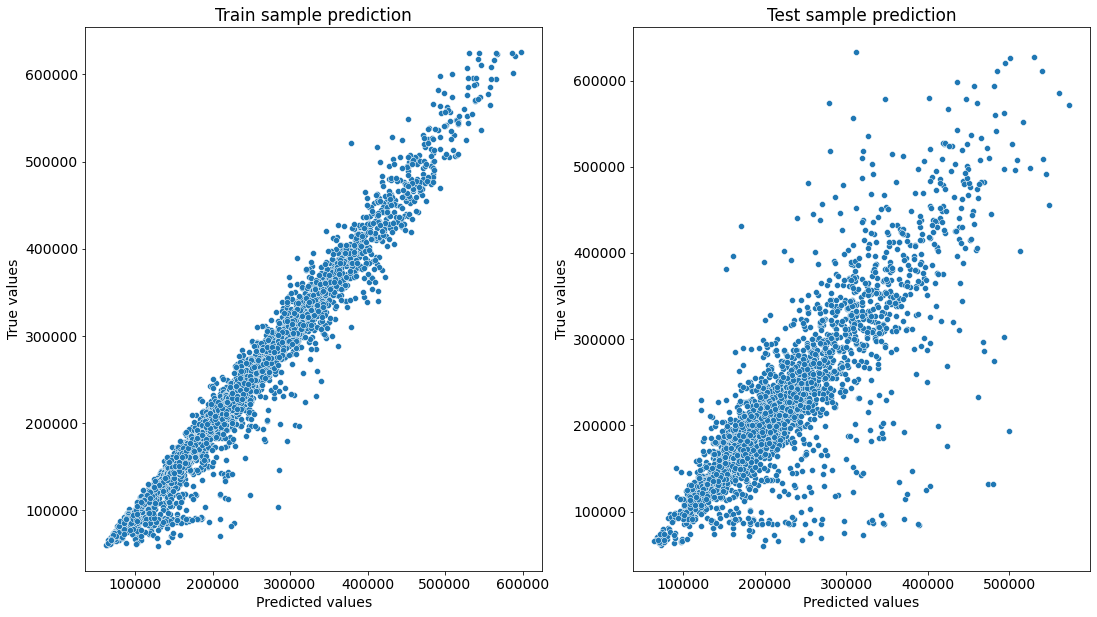

In [197]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [198]:
models_dict['RandomForestRegressor'] = rf_model

#### Кросс-валидация

In [199]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72030192, 0.73764196, 0.73866862])

In [200]:
cv_score.mean()

0.7322041663891277

In [201]:
models_dict['Кросс-валидация'] = cv_score

#### Важность признаков

In [202]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.413331
23,MedPriceByDistrict,0.301059
0,Rooms,0.032625
24,MedPriceByFloorYear,0.031118
2,LifeSquare,0.029440
12,Social_3,0.026588
6,HouseYear,0.024743
5,HouseFloor,0.019030
4,Floor,0.018458
20,DistrictSize,0.018352


### Подводим итоги

In [203]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=21))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.906
Test R2:	0.71


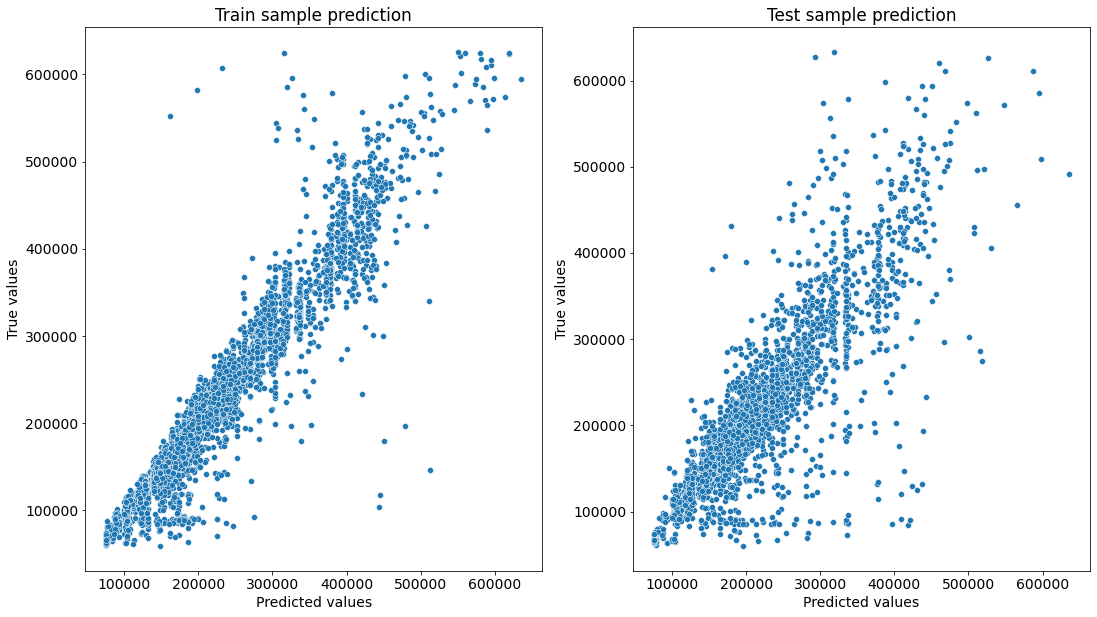

In [204]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Прогнозирование на тестовом датасете

In [205]:
test.shape

(5000, 19)

In [211]:
test['Price'] = predictions
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,163793.789352
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,197558.230105
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,399780.883236
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,331169.653365
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,149362.852962


In [212]:
test[['Id', 'Price']].to_csv('AGorokhova_predictions.csv', index=False)